In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
from scipy.spatial.distance import cityblock, mahalanobis, euclidean


In [2]:
data = pd.read_csv("DSL-StrongPasswordData.csv")

In [3]:
# 51 total
subjects = data["subject"].unique()
# METRICHE: FAR (V),FRR (V),TAR (V),TRR (V),EER (V);ROC (V),Zero error rate,Zero FRR, Zero FAR, Detection error trade off

In [31]:
def evaluateEER_with_FAR_FRR(user_scores, imposter_scores):
    labels = [0] * len(user_scores) + [1] * len(imposter_scores)
    scores = user_scores + imposter_scores
    fpr, tpr, thresholds = roc_curve(labels, scores)
    
    missrates = 1 - tpr  # False Rejection Rate (FRR)
    farates = fpr        # False Acceptance Rate (FAR)
    
    # Find the Equal Error Rate (EER)
    dists = missrates - farates
    idx1 = np.argmin(dists[dists >= 0])
    idx2 = np.argmax(dists[dists < 0])
    x = [missrates[idx1], farates[idx1]]
    y = [missrates[idx2], farates[idx2]]
    a = (x[0] - x[1]) / (y[1] - x[1] - y[0] + x[0])  # come fa l interpolazione??????????????????????????????????????????????????????????????????????????????????????????
    eer = x[0] + a * (y[0] - x[0])
    
    # Trova i valori di FAR e FRR al punto EER
    far_at_eer = farates[idx1]
    frr_at_eer = missrates[idx1]
    
    return eer, far_at_eer, frr_at_eer

def plot_figure(user_scores, imposter_scores):
    labels = [0] * len(user_scores) + [1] * len(imposter_scores)
    scores = user_scores + imposter_scores
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 1
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return


def evaluateFAR_FRR(user_scores, imposter_scores):
    labels = [0] * len(user_scores) + [1] * len(imposter_scores)
    scores = user_scores + imposter_scores
    farates, tpr, thresholds = roc_curve(labels, scores)
    
    frrates = 1 - tpr  # False Rejection Rate (FRR)
    
    return list(map(tuple,np.dstack((farates, frrates, thresholds)).reshape(-1,3)))
    


def closest_z_to_target(subjects, target_z):
    """
    For each subject, find the tuple with the closest z to the target value.

    Args:
        subjects (list): A list of subjects, where each subject is a list of tuples (x, y, z).
        target_z (int): The target z value.

    Returns:
        list: A list containing the closest tuple for each subject.
    """
    closest_tuples = []

    for subject in subjects:
        # Find the tuple with the smallest difference in z
        closest_tuple = min(subject, key=lambda t: abs(t[2] - target_z))
        closest_tuples.append(closest_tuple)

    return closest_tuples


def calculate_treshold_scores(new,min=30,max=60,decimal=False):
    
    scores =[]
    if decimal:
        for i in np.linspace(min,max,30):
            values = closest_z_to_target(new,i)
            x = np.mean([val[0] for val in values])
            y = np.mean([val[1] for val in values])
            z = np.mean([val[2] for val in values])
            scores.append((round(x,6),round(y,6),round(i,6),round(z,6)))
        return scores
    else:
        for i in range(min,max):
            values = closest_z_to_target(new,i)
            x = np.mean([val[0] for val in values])
            y = np.mean([val[1] for val in values])
            z = np.mean([val[2] for val in values])
            scores.append((x,y,i,z))
        return scores

    


In [40]:
class EuclideanDetector:
    
    def __init__(self, subjects):
        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.mean_vector = self.train.mean().values
        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cur_score = np.linalg.norm(self.test_genuine.iloc[i].values - self.mean_vector)
            self.user_scores.append(cur_score)
            
        for i in range(self.test_imposter.shape[0]):
            cur_score = np.linalg.norm(self.test_imposter.iloc[i].values - self.mean_vector)
            self.imposter_scores.append(cur_score)
    
    def evaluate(self):
        eers = []
        fars = []
        frrs = []
        evaluation=[]

        
        for subject in subjects:
            self.user_scores = []
            self.imposter_scores = []
    
            # Considera il soggetto corrente come genuino e gli altri come impostori
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # Dati di addestramento e test
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            self.testing()
    
            # Calcola EER, FAR, FRR
            eer, far, frr = evaluateEER_with_FAR_FRR(self.user_scores, self.imposter_scores)
            val= evaluateFAR_FRR(self.user_scores, self.imposter_scores)
            evaluation.append(val)

            eers.append(eer)
            fars.append(far)
            frrs.append(frr)
        
        plot_figure(self.user_scores, self.imposter_scores)
        scores = calculate_treshold_scores(evaluation,0,1,True)


        return { "AVG EER": np.mean(eers),"STDEV EER": np.std(eers),"FAR": np.mean(fars),"FRR": np.mean(frrs),"TRR": 1-np.mean(fars),"TAR": 1-np.mean(frrs), "ROC": scores} 
    

In [47]:
class EuclideanNormedDetector:
    
    def __init__(self, subjects):

        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.mean_vector = self.train.mean().values
        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cur_score = np.linalg.norm(self.test_genuine.iloc[i].values - self.mean_vector)**2
            cur_score = cur_score / np.linalg.norm(self.test_genuine.iloc[i].values)
            cur_score = cur_score / np.linalg.norm(self.mean_vector)
            self.user_scores.append(cur_score)
            
        for i in range(self.test_imposter.shape[0]):
            cur_score = np.linalg.norm(self.test_imposter.iloc[i].values - self.mean_vector)**2
            cur_score = cur_score / np.linalg.norm(self.test_imposter.iloc[i].values)
            cur_score = cur_score / np.linalg.norm(self.mean_vector)
            self.imposter_scores.append(cur_score)
    
    def evaluate(self):
        eers = []
        fars = []
        frrs = []
        evaluation=[]
        
        for subject in subjects:
            self.user_scores = []
            self.imposter_scores = []
    
            # Considera il soggetto corrente come genuino e gli altri come impostori
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # Dati di addestramento e test
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            self.testing()
    
            # Calcola EER, FAR, FRR
            eer, far, frr = evaluateEER_with_FAR_FRR(self.user_scores, self.imposter_scores)
            val= evaluateFAR_FRR(self.user_scores, self.imposter_scores)
            evaluation.append(val)

            eers.append(eer)
            fars.append(far)
            frrs.append(frr)
        
        plot_figure(self.user_scores, self.imposter_scores)
        scores = calculate_treshold_scores(evaluation,0,1,True)


        return { "AVG EER": np.mean(eers),"STDEV EER": np.std(eers),"FAR": np.mean(fars),"FRR": np.mean(frrs),"TRR": 1-np.mean(fars),"TAR": 1-np.mean(frrs), "ROC": scores} 

In [52]:
class ManhattanDetector:
    
    def __init__(self, subjects):

        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.mean_vector = self.train.mean().values
        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cur_score = cityblock(self.test_genuine.iloc[i].values, self.mean_vector)
            self.user_scores.append(cur_score)
            
        for i in range(self.test_imposter.shape[0]):
            cur_score = cityblock(self.test_imposter.iloc[i].values, self.mean_vector)
            self.imposter_scores.append(cur_score)
    
    def evaluate(self):
        eers = []
        fars = []
        frrs = []
        evaluation=[]
        
        for subject in subjects:
            self.user_scores = []
            self.imposter_scores = []
    
            # Considera il soggetto corrente come genuino e gli altri come impostori
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # Dati di addestramento e test
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            self.testing()
    
            # Calcola EER, FAR, FRR
            eer, far, frr = evaluateEER_with_FAR_FRR(self.user_scores, self.imposter_scores)
            val= evaluateFAR_FRR(self.user_scores, self.imposter_scores)
            evaluation.append(val)

            eers.append(eer)
            fars.append(far)
            frrs.append(frr)
        
        plot_figure(self.user_scores, self.imposter_scores)
        scores = calculate_treshold_scores(evaluation,1,3,True)


        return { "AVG EER": np.mean(eers),"STDEV EER": np.std(eers),"FAR": np.mean(fars),"FRR": np.mean(frrs),"TRR": 1-np.mean(fars),"TAR": 1-np.mean(frrs), "ROC": scores} 

In [32]:
class ManhattanFilteredDetector:
    
    def __init__(self, subjects):

        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.mean_vector = self.train.mean().values
        self.std_vector = self.train.std().values
        dropping_indices = []
        for i in range(self.train.shape[0]):
            cur_score = euclidean(self.train.iloc[i].values, self.mean_vector)
            if (cur_score > 3*self.std_vector).all() == True:
                dropping_indices.append(i)
        self.train = self.train.drop(self.train.index[dropping_indices])
        self.mean_vector = self.train.mean().values
        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cur_score = cityblock(self.test_genuine.iloc[i].values, self.mean_vector)
            self.user_scores.append(cur_score)
            
        for i in range(self.test_imposter.shape[0]):
            cur_score = cityblock(self.test_imposter.iloc[i].values, self.mean_vector)
            self.imposter_scores.append(cur_score)
    
    def evaluate(self):
        eers = []
        fars = []
        frrs = []
        evaluation=[]
        
        for subject in subjects:
            self.user_scores = []
            self.imposter_scores = []
    
            # Considera il soggetto corrente come genuino e gli altri come impostori
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # Dati di addestramento e test
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            self.testing()
    
            # Calcola EER, FAR, FRR
            eer, far, frr = evaluateEER_with_FAR_FRR(self.user_scores, self.imposter_scores)
            val= evaluateFAR_FRR(self.user_scores, self.imposter_scores)
            evaluation.append(val)

            eers.append(eer)
            fars.append(far)
            frrs.append(frr)
        
        plot_figure(self.user_scores, self.imposter_scores)
        scores = calculate_treshold_scores(evaluation,1,4,True)


        return { "AVG EER": np.mean(eers),"STDEV EER": np.std(eers),"FAR": np.mean(fars),"FRR": np.mean(frrs),"TRR": 1-np.mean(fars),"TAR": 1-np.mean(frrs), "ROC": scores} 

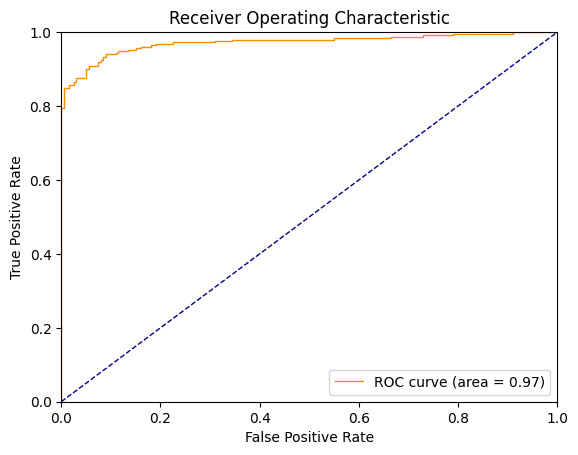

{'AVG EER': 0.12534927998872925,
 'STDEV EER': 0.08129721664813294,
 'FAR': 0.12441176470588236,
 'FRR': 0.13192156862745097,
 'TRR': 0.8755882352941177,
 'TAR': 0.868078431372549,
 'ROC': [(0.684412, 0.004549, 1.0, 1.077241),
  (0.583922, 0.008392, 1.103448, 1.18959),
  (0.526471, 0.014118, 1.206897, 1.256269),
  (0.462451, 0.022431, 1.310345, 1.330404),
  (0.392157, 0.031059, 1.413793, 1.439608),
  (0.333922, 0.043451, 1.517241, 1.561759),
  (0.297647, 0.058196, 1.62069, 1.643316),
  (0.264608, 0.075451, 1.724138, 1.746918),
  (0.234608, 0.095137, 1.827586, 1.840541),
  (0.210588, 0.115373, 1.931034, 1.950486),
  (0.191471, 0.131137, 2.034483, 2.034577),
  (0.175196, 0.15349, 2.137931, 2.128335),
  (0.164216, 0.173882, 2.241379, 2.211977),
  (0.144314, 0.195059, 2.344828, 2.331149),
  (0.134804, 0.21051, 2.448276, 2.413084),
  (0.107941, 0.225333, 2.551724, 2.519854),
  (0.096961, 0.247294, 2.655172, 2.61221),
  (0.08951, 0.263922, 2.758621, 2.692051),
  (0.083431, 0.280549, 2.862069

In [33]:
ManhattanFilteredDetector(subjects).evaluate()

In [60]:
class ManhattanScaledDetector:
    # TRESHOLD  (0.141471, 0.088235, 43.37931, 44.23806)
    
    def __init__(self, subjects):

        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.mean_vector = self.train.mean().values
        self.mad_vector = self.train.sub(self.mean_vector, axis=1).abs().mean().values

        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cur_score = 0
            for j in range(len(self.mean_vector)):
                cur_score = cur_score + \
                            abs(self.test_genuine.iloc[i].values[j] - \
                                self.mean_vector[j]) / self.mad_vector[j]
            self.user_scores.append(cur_score)
            
        for i in range(self.test_imposter.shape[0]):
            cur_score = 0
            for j in range(len(self.mean_vector)):
                cur_score = cur_score + \
                            abs(self.test_imposter.iloc[i].values[j] - \
                                self.mean_vector[j]) / self.mad_vector[j]
            self.imposter_scores.append(cur_score)
    
    def evaluate(self):
        eers = []
        fars = []
        frrs = []

        evaluation=[]
        
        for subject in subjects:
            self.user_scores = []
            self.imposter_scores = []
    
            # Considera il soggetto corrente come genuino e gli altri come impostori
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # Dati di addestramento e test
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            self.testing()
    
            # Calcola EER, FAR, FRR
            eer, far, frr = evaluateEER_with_FAR_FRR(self.user_scores, self.imposter_scores)
            
            val= evaluateFAR_FRR(self.user_scores, self.imposter_scores)
            evaluation.append(val)

            eers.append(eer)
            fars.append(far)
            frrs.append(frr)
        
        plot_figure(self.user_scores, self.imposter_scores)
        scores = calculate_treshold_scores(evaluation,40,47,True)


        return { "AVG EER": np.mean(eers),"STDEV EER": np.std(eers),"FAR": np.mean(fars),"FRR": np.mean(frrs),"TRR": 1-np.mean(fars),"TAR": 1-np.mean(frrs), "ROC": scores} 

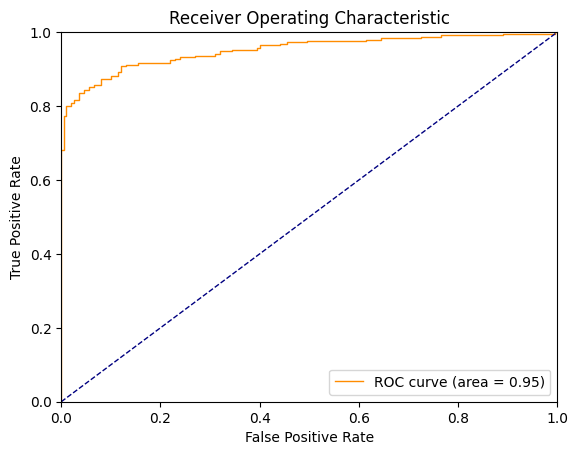

{'AVG EER': 0.09454084318639254,
 'STDEV EER': 0.0683741755687022,
 'FAR': 0.09372549019607844,
 'FRR': 0.10313725490196078,
 'TRR': 0.9062745098039215,
 'TAR': 0.8968627450980392,
 'ROC': [(0.208431, 0.059294, 40.0, 41.041398),
  (0.20598, 0.060549, 40.241379, 41.147995),
  (0.197549, 0.061725, 40.482759, 41.5089),
  (0.196471, 0.06502, 40.724138, 41.643383),
  (0.192549, 0.066196, 40.965517, 41.828801),
  (0.180686, 0.069098, 41.206897, 42.166678),
  (0.178039, 0.070039, 41.448276, 42.27681),
  (0.174902, 0.073882, 41.689655, 42.499294),
  (0.17049, 0.075529, 41.931034, 42.685131),
  (0.160882, 0.077333, 42.172414, 43.172008),
  (0.158824, 0.078745, 42.413793, 43.281906),
  (0.154902, 0.080157, 42.655172, 43.457035),
  (0.14902, 0.083216, 42.896552, 43.72147),
  (0.145294, 0.087059, 43.137931, 44.025736),
  (0.141471, 0.088235, 43.37931, 44.23806),
  (0.139412, 0.089961, 43.62069, 44.32484),
  (0.137157, 0.091843, 43.862069, 44.464237),
  (0.13049, 0.095216, 44.103448, 44.877014),
  

In [61]:
ManhattanScaledDetector(subjects).evaluate() #MIGLIORATI con cambio di training

In [36]:
class MahalanobisDetector:
    
    def __init__(self, subjects):

        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.mean_vector = self.train.mean().values
        self.covinv = np.linalg.inv(np.cov(self.train.T))        
        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            diff = self.test_genuine.iloc[i].values - self.mean_vector
            cur_score = np.dot(np.dot(diff.T, self.covinv), diff)
            self.user_scores.append(cur_score)
            
        for i in range(self.test_imposter.shape[0]):
            diff = self.test_imposter.iloc[i].values - self.mean_vector
            cur_score = np.dot(np.dot(diff.T, self.covinv), diff)
            self.imposter_scores.append(cur_score)
    
    def evaluate(self):
        eers = []
        fars = []
        frrs = []
        evaluation=[]
        
        for subject in subjects:
            self.user_scores = []
            self.imposter_scores = []
    
            # Considera il soggetto corrente come genuino e gli altri come impostori
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # Dati di addestramento e test
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            self.testing()
    
            # Calcola EER, FAR, FRR
            eer, far, frr = evaluateEER_with_FAR_FRR(self.user_scores, self.imposter_scores)
            val= evaluateFAR_FRR(self.user_scores, self.imposter_scores)
            evaluation.append(val)

            eers.append(eer)
            fars.append(far)
            frrs.append(frr)
        
        plot_figure(self.user_scores, self.imposter_scores)
        scores = calculate_treshold_scores(evaluation,30,60)


        return { "AVG EER": np.mean(eers),"STDEV EER": np.std(eers),"FAR": np.mean(fars),"FRR": np.mean(frrs),"TRR": 1-np.mean(fars),"TAR": 1-np.mean(frrs), "ROC": scores} 

In [13]:
class MahalanobisNormedDetector:
    
    def __init__(self, subjects):

        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.mean_vector = self.train.mean().values
        self.covinv = np.linalg.inv(np.cov(self.train.T))        
        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            diff = self.test_genuine.iloc[i].values - self.mean_vector
            cur_score = np.dot(np.dot(diff.T, self.covinv), diff)
            self.user_scores.append(cur_score)
            
        for i in range(self.test_imposter.shape[0]):
            diff = self.test_imposter.iloc[i].values - self.mean_vector
            cur_score = np.dot(np.dot(diff.T, self.covinv), diff)
            self.imposter_scores.append(cur_score)
    
    def evaluate(self):
        eers = []
        fars = []
        frrs = []
        
        for subject in subjects:
            self.user_scores = []
            self.imposter_scores = []
    
            # Considera il soggetto corrente come genuino e gli altri come impostori
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # Dati di addestramento e test
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            self.testing()
    
            # Calcola EER, FAR, FRR
            eer, far, frr = evaluateEER_with_FAR_FRR(self.user_scores, self.imposter_scores)
            eers.append(eer)
            fars.append(far)
            frrs.append(frr)
        
        plot_figure(self.user_scores, self.imposter_scores)
        return { "AVG EER": np.mean(eers),"STDEV EER": np.std(eers),"FAR": np.mean(fars),"FRR": np.mean(frrs),"TRR": 1-np.mean(fars),"TAR": 1-np.mean(frrs)} 

In [14]:
class NearestNeighbourMahalanobisDetector:
    
    def __init__(self, subjects):

        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.covinv = np.linalg.inv(np.cov(self.train.T))        
        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cur_scores = []
            for j in range(self.train.shape[0]):
                diff = self.test_genuine.iloc[i].values - self.train.iloc[j]
                cur_scores.append(np.dot(np.dot(diff.T, self.covinv), diff))
            self.user_scores.append(min(cur_scores))
            
        for i in range(self.test_imposter.shape[0]):
            cur_scores = []
            for j in range(self.train.shape[0]):
                diff = self.test_imposter.iloc[i].values - self.train.iloc[j]
                cur_scores.append(np.dot(np.dot(diff.T, self.covinv), diff))
            self.imposter_scores.append(min(cur_scores))
    
    def evaluate(self):
        eers = []
        fars = []
        frrs = []
        
        for subject in subjects:
            self.user_scores = []
            self.imposter_scores = []
    
            # Considera il soggetto corrente come genuino e gli altri come impostori
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # Dati di addestramento e test
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            self.testing()
    
            # Calcola EER, FAR, FRR
            eer, far, frr = evaluateEER_with_FAR_FRR(self.user_scores, self.imposter_scores)
            eers.append(eer)
            fars.append(far)
            frrs.append(frr)
        
        plot_figure(self.user_scores, self.imposter_scores)
        return { "AVG EER": np.mean(eers),"STDEV EER": np.std(eers),"FAR": np.mean(fars),"FRR": np.mean(frrs),"TRR": 1-np.mean(fars),"TAR": 1-np.mean(frrs)} 

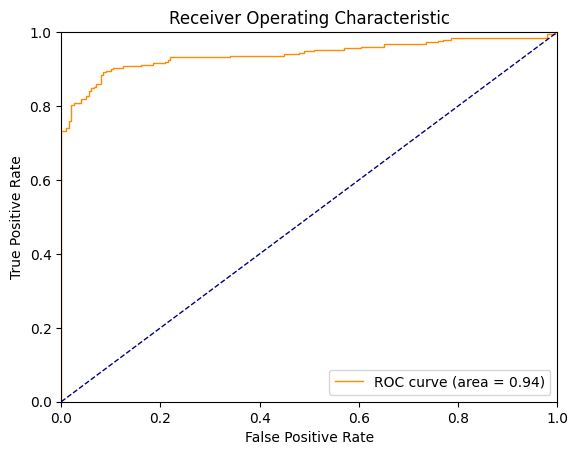

{'AVG EER': 0.16928649036431045,
 'STDEV EER': 0.09313837450860046,
 'FAR': 0.16784313725490196,
 'FRR': 0.17623529411764705,
 'TRR': 0.832156862745098,
 'TAR': 0.823764705882353,
 'ROC': [(1.0, 0.0, 0.0, 0.213248),
  (1.0, 0.0, 0.034483, 0.213248),
  (1.0, 0.0, 0.068966, 0.213248),
  (1.0, 0.0, 0.103448, 0.213248),
  (1.0, 7.8e-05, 0.137931, 0.213447),
  (0.99951, 0.000157, 0.172414, 0.21632),
  (0.920098, 0.00149, 0.206897, 0.251756),
  (0.90402, 0.004314, 0.241379, 0.267823),
  (0.832353, 0.010431, 0.275862, 0.295607),
  (0.726765, 0.018588, 0.310345, 0.331793),
  (0.645784, 0.030275, 0.344828, 0.355926),
  (0.546765, 0.046431, 0.37931, 0.392798),
  (0.48049, 0.061255, 0.413793, 0.42193),
  (0.410392, 0.078667, 0.448276, 0.451588),
  (0.349804, 0.098902, 0.482759, 0.484518),
  (0.302843, 0.12251, 0.517241, 0.521052),
  (0.269314, 0.144784, 0.551724, 0.553283),
  (0.238333, 0.16902, 0.586207, 0.587745),
  (0.214608, 0.192314, 0.62069, 0.619291),
  (0.197745, 0.214431, 0.655172, 0.649

In [41]:
EuclideanDetector(subjects).evaluate()

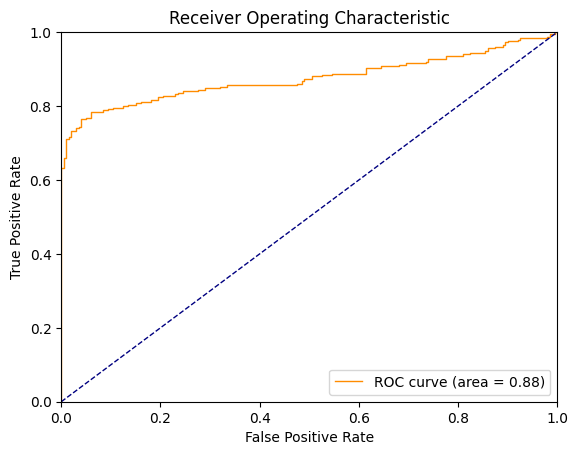

{'AVG EER': 0.21069715231915348,
 'STDEV EER': 0.11740261528927776,
 'FAR': 0.20872549019607842,
 'FRR': 0.21827450980392152,
 'TRR': 0.7912745098039216,
 'TAR': 0.7817254901960785,
 'ROC': [(1.0, 0.0, 0.0, 0.031996),
  (0.984706, 0.000863, 0.034483, 0.035876),
  (0.897843, 0.01051, 0.068966, 0.067769),
  (0.747745, 0.033176, 0.103448, 0.104925),
  (0.610392, 0.070588, 0.137931, 0.138254),
  (0.487745, 0.111059, 0.172414, 0.171554),
  (0.375392, 0.153098, 0.206897, 0.207667),
  (0.294804, 0.20102, 0.241379, 0.241257),
  (0.232647, 0.242039, 0.275862, 0.274918),
  (0.186765, 0.283137, 0.310345, 0.308936),
  (0.152059, 0.320157, 0.344828, 0.345431),
  (0.125588, 0.358902, 0.37931, 0.379049),
  (0.102745, 0.389882, 0.413793, 0.413871),
  (0.086373, 0.421176, 0.448276, 0.449219),
  (0.069902, 0.443843, 0.482759, 0.480186),
  (0.060882, 0.468941, 0.517241, 0.513905),
  (0.052745, 0.495294, 0.551724, 0.548571),
  (0.04598, 0.519686, 0.586207, 0.584471),
  (0.040882, 0.532706, 0.62069, 0.6089

In [48]:
EuclideanNormedDetector(subjects).evaluate()

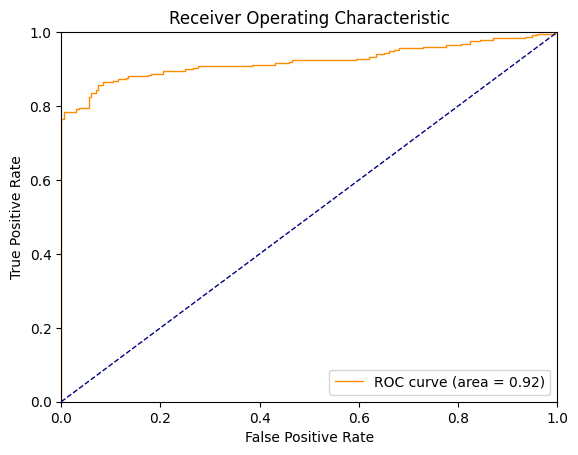

{'AVG EER': 0.15026997944690795,
 'STDEV EER': 0.09094241735620097,
 'FAR': 0.1493137254901961,
 'FRR': 0.15600000000000003,
 'TRR': 0.8506862745098039,
 'TAR': 0.844,
 'ROC': [(0.854706, 0.004471, 1.0, 1.105992),
  (0.832451, 0.006275, 1.068966, 1.137603),
  (0.795098, 0.009176, 1.137931, 1.19628),
  (0.722353, 0.013961, 1.206897, 1.290738),
  (0.680784, 0.019137, 1.275862, 1.33264),
  (0.637843, 0.025725, 1.344828, 1.382903),
  (0.57451, 0.032627, 1.413793, 1.479608),
  (0.52951, 0.042039, 1.482759, 1.543286),
  (0.481471, 0.051922, 1.551724, 1.605584),
  (0.439804, 0.061647, 1.62069, 1.661241),
  (0.402647, 0.07302, 1.689655, 1.714087),
  (0.370882, 0.084314, 1.758621, 1.770427),
  (0.337059, 0.098667, 1.827586, 1.840831),
  (0.307353, 0.111059, 1.896552, 1.901601),
  (0.283235, 0.122588, 1.965517, 1.96298),
  (0.263922, 0.140157, 2.034483, 2.028578),
  (0.233333, 0.151059, 2.103448, 2.107192),
  (0.215392, 0.166353, 2.172414, 2.193582),
  (0.204902, 0.180235, 2.241379, 2.248857),
 

In [53]:
ManhattanDetector(subjects).evaluate()

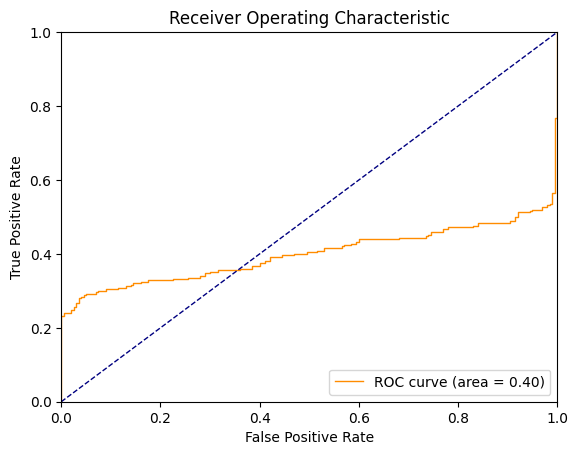

{'AVG EER': 0.24790454682491153,
 'STDEV EER': 0.13839594727575688,
 'FAR': 0.24519607843137256,
 'FRR': 0.25482352941176467,
 'TRR': 0.7548039215686274,
 'TAR': 0.7451764705882353,
 'ROC': [(0.3592156862745097, 0.22807843137254907, 30, -4936034733755342.0),
  (0.3512745098039216, 0.23247058823529415, 31, -4936034733755341.0),
  (0.3438235294117647, 0.2356078431372549, 32, -4936034733755341.0),
  (0.33460784313725495, 0.23882352941176474, 33, -4936034733755341.0),
  (0.3276470588235294, 0.24172549019607845, 34, -4936034733755340.0),
  (0.31529411764705884, 0.24541176470588236, 35, -4936034733755339.0),
  (0.3066666666666667, 0.2487058823529412, 36, -4936034733755338.0),
  (0.29696078431372547, 0.2531764705882352, 37, -4936034733755337.0),
  (0.28941176470588237, 0.2557647058823529, 38, -4936034733755335.0),
  (0.27931372549019606, 0.2587450980392157, 39, -4936034733755334.0),
  (0.2726470588235294, 0.2632156862745098, 40, -4936034733755334.0),
  (0.2642156862745098, 0.26627450980392153

In [54]:
MahalanobisDetector(subjects).evaluate()

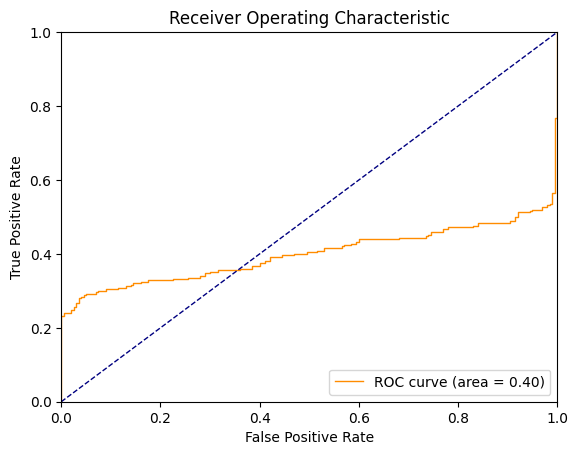

{'AVG EER': 0.24790454682491153,
 'STDEV EER': 0.13839594727575688,
 'FAR': 0.24519607843137256,
 'FRR': 0.25482352941176467,
 'TRR': 0.7548039215686274,
 'TAR': 0.7451764705882353}

In [ ]:
MahalanobisNormedDetector(subjects).evaluate()

In [ ]:
#NearestNeighbourMahalanobisDetector(subjects).evaluate() lento o bug?

In [58]:
class OutlierCountingDetector:
    
    def __init__(self, subjects):

        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.mean_vector = self.train.mean().values
        self.std_vector = self.train.std().values
        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cnt = 0.0
            for j in range(len(self.mean_vector)):
                cur_score = abs(self.test_genuine.iloc[i].values[j] - \
                                self.mean_vector[j]) // self.std_vector[j]
                if cur_score > 2.96:
                    cnt = cnt + 1.0
            self.user_scores.append(cnt)
            
        for i in range(self.test_imposter.shape[0]):
            cnt = 0.0
            for j in range(len(self.mean_vector)):
                cur_score = abs(self.test_imposter.iloc[i].values[j] - \
                                self.mean_vector[j]) // self.std_vector[j]
                if cur_score > 2.96:
                    cnt = cnt + 1.0     
            self.imposter_scores.append(cnt)
    
    def evaluate(self):
        eers = []
        fars = []
        frrs = []
        evaluation=[]
        
        for subject in subjects:
            self.user_scores = []
            self.imposter_scores = []
    
            # Considera il soggetto corrente come genuino e gli altri come impostori
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # Dati di addestramento e test
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            self.testing()
    
            # Calcola EER, FAR, FRR
            eer, far, frr = evaluateEER_with_FAR_FRR(self.user_scores, self.imposter_scores)
            val= evaluateFAR_FRR(self.user_scores, self.imposter_scores)
            evaluation.append(val)

            eers.append(eer)
            fars.append(far)
            frrs.append(frr)
        
        plot_figure(self.user_scores, self.imposter_scores)
        scores = calculate_treshold_scores(evaluation,0,2,True)


        return { "AVG EER": np.mean(eers),"STDEV EER": np.std(eers),"FAR": np.mean(fars),"FRR": np.mean(frrs),"TRR": 1-np.mean(fars),"TAR": 1-np.mean(frrs), "ROC": scores} 

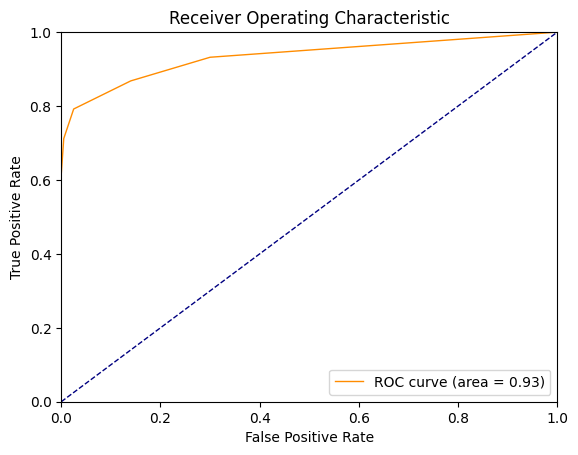

{'AVG EER': 0.10309683453558674,
 'STDEV EER': 0.07685487844204786,
 'FAR': 0.09186274509803921,
 'FRR': 0.19309803921568625,
 'TRR': 0.9081372549019608,
 'TAR': 0.8069019607843138,
 'ROC': [(1.0, 0.0, 0.0, 0.0),
  (1.0, 0.0, 0.068966, 0.0),
  (1.0, 0.0, 0.137931, 0.0),
  (1.0, 0.0, 0.206897, 0.0),
  (1.0, 0.0, 0.275862, 0.0),
  (1.0, 0.0, 0.344828, 0.0),
  (1.0, 0.0, 0.413793, 0.0),
  (1.0, 0.0, 0.482759, 0.0),
  (0.26902, 0.086196, 0.551724, 1.0),
  (0.26902, 0.086196, 0.62069, 1.0),
  (0.26902, 0.086196, 0.689655, 1.0),
  (0.26902, 0.086196, 0.758621, 1.0),
  (0.26902, 0.086196, 0.827586, 1.0),
  (0.26902, 0.086196, 0.896552, 1.0),
  (0.26902, 0.086196, 0.965517, 1.0),
  (0.26902, 0.086196, 1.034483, 1.0),
  (0.26902, 0.086196, 1.103448, 1.0),
  (0.26902, 0.086196, 1.172414, 1.0),
  (0.26902, 0.086196, 1.241379, 1.0),
  (0.26902, 0.086196, 1.310345, 1.0),
  (0.26902, 0.086196, 1.37931, 1.0),
  (0.26902, 0.086196, 1.448276, 1.0),
  (0.139608, 0.174039, 1.517241, 1.980392),
  (0.13960

In [59]:
OutlierCountingDetector(subjects).evaluate() #Good 